# AI Trading : KNN using OC and HL difference


We will be using KNN (can be extended later) in order to trade a model that uses 
1. the difference between Open and Close 
2. the difference between High and Low

This is the starting point of other research papers that will follow

## Import Libraries

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import quandl
quandl.ApiConfig.api_key = 'YOUR_TOKEN' # it is free for end of day data, you just need to create a user

## Load data

In [122]:
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2018-01-01')
SP500 = quandl.get(["CHRIS/CME_SP1.1","CHRIS/CME_SP1.2","CHRIS/CME_SP1.3","CHRIS/CME_SP1.4"],start_date=start,end_date=end)#4 to keep only Last/CLose

In [123]:
SP500.columns = ['Open','High','Low','Close']

In [124]:
SP500 = SP500.dropna()

Text(0.5,1,'SP500 Close')

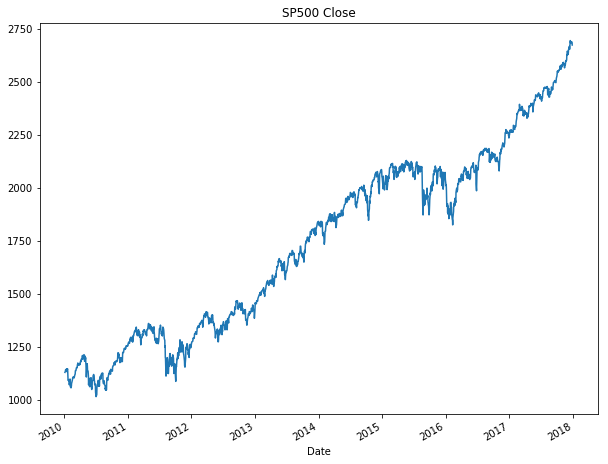

In [125]:
SP500['Close'].plot(figsize=(10,8))
plt.title('SP500 Close')

## Build Predicators

In [126]:
SP500['Open-Close']= (SP500.Open - SP500.Close)/SP500.Close # predicator 1
SP500['High-Low']= (SP500.High - SP500.Low)/SP500.Close # predicator 2
SP500 = SP500.dropna()
X = SP500[['Open-Close','High-Low']]
SP500.head()

,Open,High,Low,Close,Open-Close,High-Low
Date,,,,,,
2010-01-04,1113.2,1129.8,1113.2,1128.8,-0.013820,0.014706
2010-01-06,1132.0,1135.5,1127.4,1133.0,-0.000883,0.007149
2010-01-07,1132.9,1138.7,1127.2,1137.5,-0.004044,0.010110
2010-01-08,1137.4,1143.0,1131.0,1141.6,-0.003679,0.010512
2010-01-11,1141.6,1147.9,1138.0,1142.5,-0.000788,0.008665


## Target variables

compare the period with the day before to define if the day was up or down

In [127]:
Y= np.where(SP500['Close'].shift(-1)>SP500['Close'],1,-1)

## Split Dataset

In [128]:
Xdf = X
split_percentage = 0.7
split = int(split_percentage*len(SP500))
X=X.values # change df into array
X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:]
Y_test = Y[split:]

## Launch K-Nearest Neighbors Algorithm

In [107]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,Y_train)
accuracy_train = accuracy_score(Y_train,knn.predict(X_train))
accuracy_test = accuracy_score(Y_test,knn.predict(X_test))
print(accuracy_train)
print(accuracy_test)

0.628388017118
0.524916943522


    The accuracy of the train set is 61,98% and the accuracy of the test set is 53,82%

## Visualising the Training Set

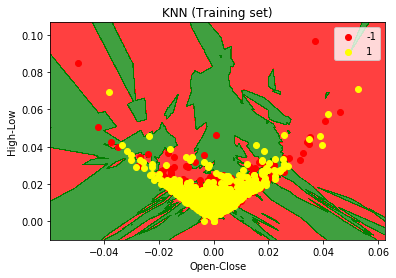

In [116]:
X_set, y_set = X_train, Y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - .01, stop = X_set[:, 0].max() + .01, step = 0.0001),
                     np.arange(start = X_set[:, 1].min() - .01, stop = X_set[:, 1].max() + .01, step = 0.0001))
plt.contourf(X1, X2, knn.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow'))(i), label = j)
plt.title('KNN (Training set)')
plt.xlabel('Open-Close')
plt.ylabel('High-Low')
plt.legend()
plt.show()

## Visualising the Test Set

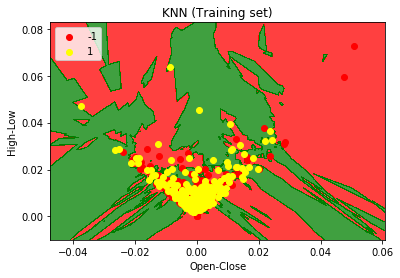

In [109]:
X_set, y_set = X_test, Y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - .01, stop = X_set[:, 0].max() + .01, step = 0.0001),
                     np.arange(start = X_set[:, 1].min() - .01, stop = X_set[:, 1].max() + .01, step = 0.0001))
plt.contourf(X1, X2, knn.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow'))(i), label = j)
plt.title('KNN (Training set)')
plt.xlabel('Open-Close')
plt.ylabel('High-Low')
plt.legend()
plt.show()

## Create the trading strategy

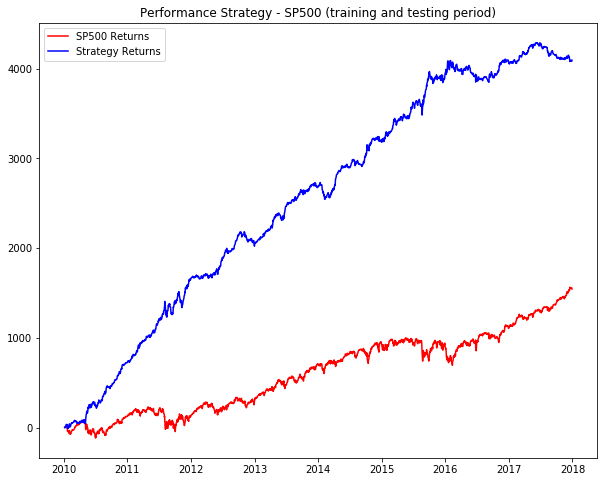

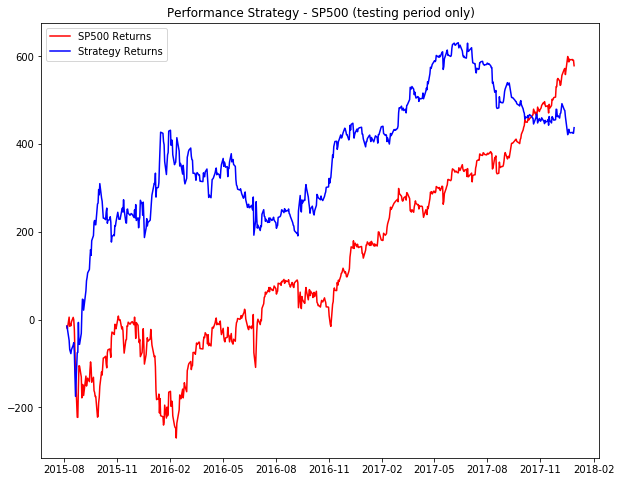

In [136]:
# predicted signals
SP500['Predicted_Signal']= knn.predict(X)

# compute SP and strategy returns total
SP500['SP_Returns'] = SP500['Close']-SP500['Close'].shift(1)
SP500['Strategy_Returns'] = SP500['SP_Returns'] * SP500['Predicted_Signal'].shift(1)
# compute SP and strategy returnson testing period
SP500test = SP500[split:]

# Strategy cumulative returns total
Cumulative_SP_Returns = SP500['SP_Returns'].cumsum()
Cumulative_Strat_Returns = SP500['Strategy_Returns'].cumsum()
# Strategy cumulative returns test
Cumulative_SP_Returns_test = SP500test['SP_Returns'].cumsum()
Cumulative_Strat_Returns_test = SP500test['Strategy_Returns'].cumsum()

# Plot the performance of SP500 and strategy total
plt.figure(figsize=(10,8))
plt.title('Performance Strategy - SP500 (training and testing period)')
plt.plot(Cumulative_SP_Returns,color='r',label='SP500 Returns')
plt.plot(Cumulative_Strat_Returns,color='b',label='Strategy Returns')
plt.legend()
plt.show()


# Plot the performance of SP500 and strategy test
plt.figure(figsize=(10,8))
plt.title('Performance Strategy - SP500 (testing period only)')
plt.plot(Cumulative_SP_Returns_test,color='r',label='SP500 Returns')
plt.plot(Cumulative_Strat_Returns_test,color='b',label='Strategy Returns')
plt.legend()
plt.show()